# Workflow to compare TISSUES and NextProt data

### Import the required packages

In [31]:
## based on the tutorial https://jensenlab.org/training/stringapp/#exercise-3

import os
import sys
from time import sleep
import pandas as pd
import matplotlib
from py2cytoscape import cyrest
from IPython.display import Image
%matplotlib inline

### Setup Cytoscape
TODO: check if apps are installed and if not, install them

In [32]:
cytoscape=cyrest.cyclient()
cytoscape.version()

(u'cytoscapeVersion', u'3.7.2')
(u'apiVersion', u'v1')


In [33]:
cytoscape.session.new()

### Protein network retrieval
Retrieve a STRING network for all UniProt identifiers in the table. 

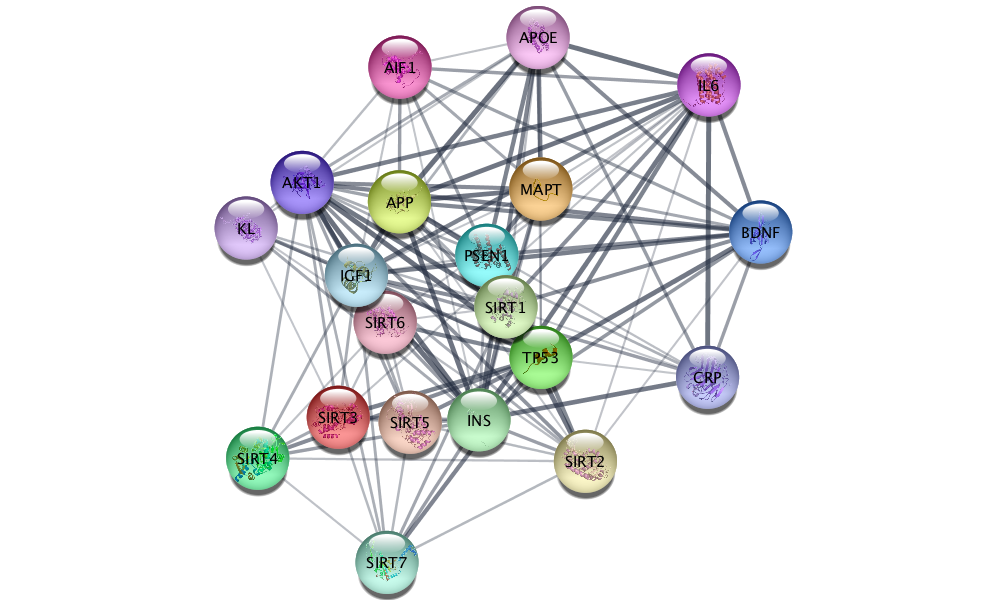

In [34]:
from py2cytoscape.cyrest.base import api
## create the string network with the uniprot ids
api(namespace="string",command="pubmed query",PARAMS={"cutoff": "0.4",
                                                      "limit": "20",
                                                      "pubmed": "aging",
                                                      "species": "homo sapiens",
                                                      "taxonID": "9606"})
sleep(2)
fig=cytoscape.networks.getFirstImageAsPng(networkId=cytoscape.network.get()["SUID"],h=None)
Image(fig.content)

### Check for obsolete UniProt IDs

In [35]:
## get list 
uniprotIDs=list(set(cytoscape.table.getTable(columns=['stringdb::canonical name'],table='node')['stringdb::canonical name']))

### for python 2

In [36]:
import urllib,urllib2
import pandas as pd

url = "https://www.uniprot.org/uploadlists/"
params = {
"from":"ACC",
"to":"ACC",
"format":"tab",
"query":" ".join(uniprotIDs)
}
data = urllib.urlencode(params)
request = urllib2.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib2.urlopen(request)

### for python 3

In [6]:

## convert from STRING UniProt IDs to current IDs / check for obsolete IDs
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse
url = "https://www.uniprot.org/uploadlists/"
params = {
"from":"ACC",
"to":"ACC",
"format":"tab",
"query":" ".join(uniprotIDs)
}
data = urllib.parse.urlencode(params).encode("utf-8")
request = urllib.request.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib.request.urlopen(request)

In [37]:
uniprot_mapping = pd.read_csv(response, sep ="\t")
uniprot_mapping.head()

,From,To
0,P55008,P55008
1,P02649,P02649
2,P31749,P31749
3,Q5CZI7,P10636
4,P05231,P05231


### Get NextProt data
here we will retrieve the nextProt data from SparQL query.

In [38]:
query="""PREFIX : <http://nextprot.org/rdf#>
PREFIX entry: <http://nextprot.org/rdf/entry/>
PREFIX isoform: <http://nextprot.org/rdf/isoform/>
PREFIX annotation: <http://nextprot.org/rdf/annotation/>
PREFIX evidence: <http://nextprot.org/rdf/evidence/>
PREFIX xref: <http://nextprot.org/rdf/xref/>
PREFIX publication: <http://nextprot.org/rdf/publication/>
PREFIX identifier: <http://nextprot.org/rdf/identifier/>
PREFIX cv: <http://nextprot.org/rdf/terminology/>
PREFIX gene: <http://nextprot.org/rdf/gene/>
PREFIX source: <http://nextprot.org/rdf/source/>
PREFIX db: <http://nextprot.org/rdf/db/>
PREFIX context: <http://nextprot.org/rdf/context/>
PREFIX interaction: <http://nextprot.org/rdf/interaction/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>
PREFIX proteoform: <http://nextprot.org/rdf/proteoform/>
select distinct ?entry str(?gen) ?PAset (count(distinct(?pm)) as ?pepcnt) where {
values ?entry { 
entry:NX_Q8N6T7
entry:NX_P55008
entry:NX_P02649
entry:NX_P05231
}
?entry :isoform ?iso .
  ?entry :gene / :name ?gen .
  ?iso :swissprotDisplayed true .   #restricts to canonical iso
  ?iso :peptideMapping ?pm .
  ?pm :proteotypic true .             #only uniquely mapping peptides
?pm :evidence / :assignedBy ?source .
    ?source rdfs:comment ?sourcename.
    bind(substr(str(?sourcename),48) as ?PAset)
  filter(regex(str(?sourcename),"PeptideAtlas"))   
  #filter (!regex(str(?sourcename), "Cancer"))   
  filter (!regex(str(?sourcename), "phosphoproteome")) 
  ?source rdfs:comment ?srcname.
  }
order by ?entry"""

### for python 2

In [39]:
import urllib,urllib2
import pandas as pd
from io import StringIO 

url = "https://sparql.nextprot.org/"

params = {
"query":query,
"format":"csv"
}

data = urllib.urlencode(params)
request = urllib2.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib2.urlopen(request)



### for python 3

In [21]:
import urllib.request, urllib.parse, urllib.error,urllib.request,urllib.error,urllib.parse

import pandas as pd
from io import StringIO 

url = "https://sparql.nextprot.org/"

params = {
"query":query,
"format":"csv"
}

data = urllib.parse.urlencode(params).encode("utf-8")
request = urllib.request.Request(url, data)
contact = "" # Please set a contact email address here to help us debug in case of problems (see https://www.uniprot.org/help/privacy).
request.add_header("User-Agent", "Python %s" % contact)
response = urllib.request.urlopen(request)

In [40]:
nextProt_output = pd.read_csv(response, sep =",")
nextProt_output.head()

,entry,callret-1,PAset,pepcnt
0,http://nextprot.org/rdf/entry/NX_P02649,APOE,Urinary Bladder,19
1,http://nextprot.org/rdf/entry/NX_P02649,APOE,Ovary,34
2,http://nextprot.org/rdf/entry/NX_P02649,APOE,Adrenal Gland,23
3,http://nextprot.org/rdf/entry/NX_P02649,APOE,"Cancer Cell Lines, Lung",11
4,http://nextprot.org/rdf/entry/NX_P02649,APOE,"Cancer Cell Lines, Other Female Reproductive O...",8


## Convert NextProt data and merge with TISSUES
Create an OmicsVisualizer table

### process data from sparql query

In [41]:
#EXPECTS nextprot_output df

# unstack data to get tissues as separate columns
unstacked = nextProt_output.set_index(['entry','PAset'])[['pepcnt']].unstack()

# add gene names back to unstacked data
genes=nextProt_output.set_index('entry')['callret-1']
mapped_genes = unstacked.index.map(genes.to_dict())
unstacked.insert(0,'gene',mapped_genes)

TypeError: 'dict' object is not callable

**process nextprot entry to get uniprot id**

In [25]:
def process_id(entry):
    return entry.strip().split('_')[-1]
unstacked.reset_index(inplace=True)
unstacked.insert(0,'uniprot_id',unstacked['entry'].apply(process_id))

**fill empty values with 0, assign proper column names**

In [26]:
result = unstacked.set_index('uniprot_id').fillna(0)
columns = list(result.columns.droplevel(level=0))
columns[0]='entry'
columns[1]='gene'
result.columns = columns

### Process node table

In [ ]:
# EXPECTS nodes DATAFRAME
nodes = cytoscape.table.getTable(table='node', columns=['stringdb::canonical name','tissue::adrenal gland',
                                                'tissue::blood','tissue::bone','tissue::bone marrow','tissue::eye', 'tissue::gall bladder',
                                                'tissue::heart', 'tissue::intestine', 'tissue::kidney','tissue::liver','tissue::lung',
                                                'tissue::muscle','tissue::nervous system','tissue::pancreas','tissue::saliva',
                                                'tissue::skin', 'tissue::spleen', 'tissue::stomach','tissue::thyroid gland', 'tissue::urine'])

In [ ]:
# find all tissues column in nodes table
nodes_tissues = [col for col in nodes.columns if 'tissue::' in col]
nodes = nodes.set_index('query term')

# select tissue columns from node table
tissue_data = nodes.loc[:,nodes_tissues]
tissue_data.head()

#### get tissue mapping between nextprot and tissuedb

In [45]:
# dictionary mapping nexprot tissues to TISSUESdb tissues
tissue_mapping = {
    'Adrenal Gland':'tissue::adrenal gland',
    'Blood Cells':'tissue::blood',
    'Blood Plasma':'tissue::blood',
    'Blood':'tissue::blood',
    'Eye':'tissue::eye',
    'Heart':'tissue::heart',
    'Kidney':'tissue::kidney',
    'Liver':'tissue::liver',
    'Lung':'tissue::lung',
    'Brain':'tissue::nervous system',
    'Cerebrospinal Fluid':'tissue::nervous system',
    'Olfactory System':'tissue::nervous system',
    'Pituitary Gland':'tissue::nervous system',
    'Pancreas':'tissue::pancreas',
    'Spleen':'tissue::spleen',
    'Thyroid':'tissue::thyroid gland',
    'Urinary Bladder':'tissue::urine',
    'Ureter':'tissue::urine',
    'Urine':'tissue::urine',
    'Alimentary System':'tissue::intestine',
}

In [46]:
# create dict with list of nextprot tissues belonging to each tissues tissue
tissues_to_np = {}

for key,value in tissue_mapping.items():
    if value in tissues_to_np.keys():
        tissues_to_np[value].append(key)
    else:
        tissues_to_np[value] = [key]

In [48]:
# stack tissues data into the required format
stacked_tissues = pd.DataFrame(tissue_data.stack())
stacked_tissues.columns=['tissues score']
stacked_tissues.head()

### determine peptide evidence for each mapped tissue from nextprot

In [ ]:
next_prot_bools = []

# go over all tissues in nodes data
for ttissue in nodes_tissues:
    # skip tissue if it doesnt map to nextprot
    if not ttissue in tissues_to_np.keys():
        continue
    # get nexprot tissues mapping to this tissue
    np_tissues = tissues_to_np[ttissue]
    # get peptide counts for all these tissues
    counts = result.loc[:,np_tissues]
    # boolean for peptide presence or absence
    summed = counts.sum(axis=1)
    bools = pd.DataFrame(summed!= 0)
    bools.columns = [ttissue]
    # add dataframe to list
    next_prot_bools.append(bools)
    
# concatenate the dataframes with nextprot boolean arrays
nextprot_result = pd.concat(next_prot_bools, axis =1) 

# stack the datataframe to be in the 
# same format as the stacked tissues data
nextprot_stacked = pd.DataFrame(nextprot_result.stack())
nextprot_stacked.reset_index(inplace=True)
nextprot_stacked.columns = ['uniprot_id','tissue','np']
nextprot_stacked.head()

#### merge stacked tissues and stacked nextprot dataframes

In [ ]:
merged_data = stacked_tissues.merge(
    nextprot_stacked,
    how='inner',
    left_index=True,
    right_on=['uniprot_id','tissue'])
merged_data = merged_data[['uniprot_id','tissue','tissues score','np']]

# strip the '::tissue' part from the tissue names
def strip_tissue(value):
    return value.split('::')[-1]
merged_data['tissue'] = merged_data['tissue'].apply(strip_tissue)
merged_data.head()


In [ ]:
merged_data.to_csv(
    './data/stacked_tissues_nextprot.tsv',
    index=False,
    sep='\t')

## Save the session

In [27]:
cytoscape.session.save_as(session_file="tissues_nextprot_merge")